Есть данные АА-теста с '2022-09-26' по '2022-10-02'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.


In [1]:
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats

In [2]:
connection = {'host': 'http://172.18.0.1:8123', 'database': 'test'}

In [3]:
query = "select value from {db}.ctl_metadata where table='test.feed_actions' and param='timedelta'"
days_shift = int(ph.read_clickhouse(query, connection=connection).min().to_list()[0])

period_old = ['2022-09-26', '2022-10-02']
period_new = [(dt.strptime(d, '%Y-%m-%d')+td(days=days_shift)).strftime('%Y-%m-%d') for d in period_old]

print("Period: {}".format(period_new))
print("Datetime delta: {}".format(days_shift))

Period: ['2022-11-10', '2022-11-16']
Datetime delta: 45


In [4]:
query = '''
    select 
        exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    from test.feed_actions 
    where exp_group in(2, 3) and toDate(time) between '{}' and '{}'
    group by exp_group, user_id
'''.format(*period_new)

feed_actions_ctr_df = ph.read_clickhouse(query, connection=connection)
feed_actions_ctr_df.head()

,exp_group,user_id,likes,views,ctr
0,2,131914,8,13,0.615385
1,3,505,6,44,0.136364
2,3,8859,5,32,0.156250
3,2,129294,16,90,0.177778
4,3,4168,12,35,0.342857


In [5]:
feed_actions_ctr_df.groupby('exp_group', as_index = False).agg({'user_id': 'count'})

,exp_group,user_id
0,2,8480
1,3,8569


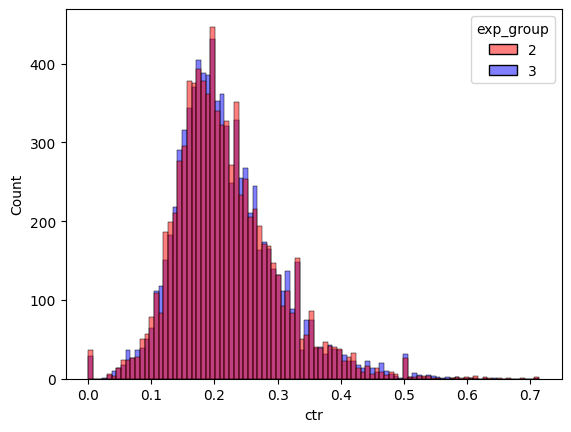

In [61]:
_ = sns.histplot(data = feed_actions_ctr_df, 
                 x='ctr', 
                 hue='exp_group', 
                 palette = ['r', 'b'],
                 alpha=0.5,
                 kde=False)

In [62]:
n_bootstraps = 10000
n_samples = 500

In [63]:
%%time

group_a1 = feed_actions_ctr_df[feed_actions_ctr_df['exp_group'] == 2]['ctr']
group_a2 = feed_actions_ctr_df[feed_actions_ctr_df['exp_group'] == 3]['ctr']

p_values = np.array([])
for _ in range(n_bootstraps):
    statistic, p_value = stats.ttest_ind(group_a1.sample(n=n_samples, replace=False), 
                                         group_a2.sample(n=n_samples, replace=False), 
                                         equal_var=True)
    p_values = np.append(p_values, p_value)

CPU times: user 8.3 s, sys: 0 ns, total: 8.3 s
Wall time: 8.4 s


In [64]:
print("Mean p-value: {}".format(np.mean(p_values)))

Mean p-value: 0.508134401622959


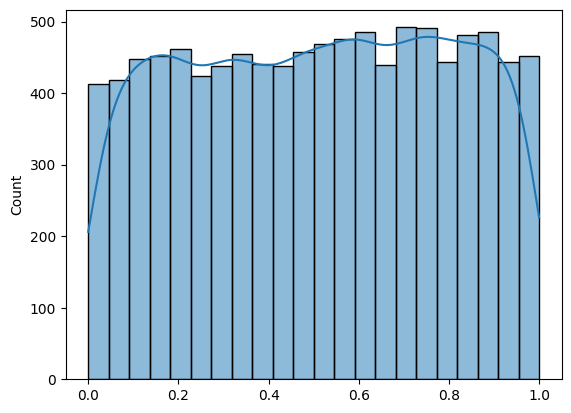

In [65]:
_ = sns.histplot(p_values, kde=True)

In [66]:
(p_values<0.05).sum()/n_bootstraps

0.0452

In [67]:
h = 0.05
eps = 0.01

# See what proportion of all samples are covered by other p-values
deltas = np.array([])
for i in range(1, int(1/h+1)):
    p = i * h
    delta = ((p-h <= p_values) & (p_values < p)).sum() / n_bootstraps
    deltas = np.append(deltas, delta)

In [68]:
print((np.abs(deltas-h)<eps).sum()/len(deltas))

1.0


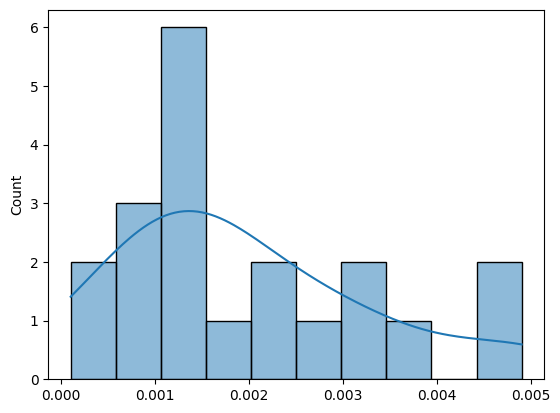

In [69]:
_ = sns.histplot(np.abs(deltas-h), bins=10, kde=True)

Распределение p-значений похоже на равномерное. Можно сделать вывод, что сплитование на группы работает корректно